C:\Users\Sajede Harraz\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


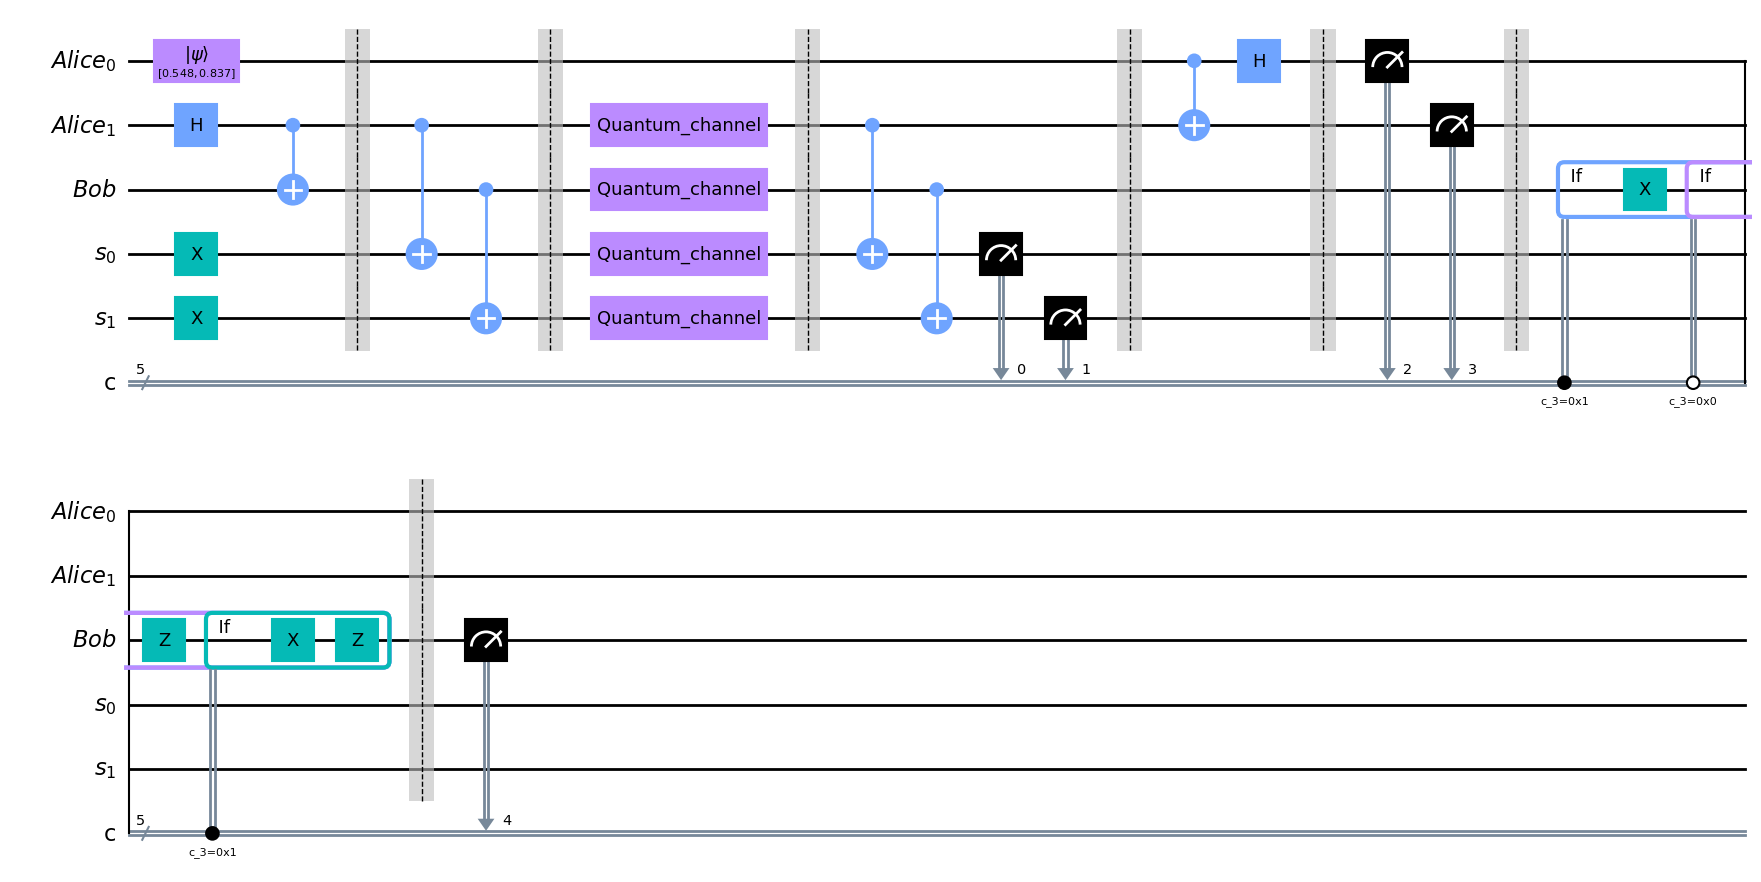

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.aer.noise import amplitude_damping_error, NoiseModel
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.tools.monitor import job_monitor
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np


qa = QuantumRegister(2, 'Alice')  # q0: state |ψ⟩, q1: Alice's entangled qubit
qb = QuantumRegister(1, 'Bob')   #q2: Bob's entangled qubit
anc = QuantumRegister(2, 's')  #q3, q4: Escort qubits (ancillas)
c = ClassicalRegister(5, 'c')  # classical bits 
qc = QuantumCircuit(qa,qb,anc, c)

#Prepare the state to teleport (arbitrary state on q0)
alpha=np.sqrt(0.3);
beta = np.sqrt(1 - alpha**2)

qc.initialize([alpha, beta], [qa[0]])


# Create a Bell pair between q1 and q2
qc.h(1)
qc.cx(1, 2)

#prepare the escort qubits in the state |1>
qc.x(3)
qc.x(4)
qc.barrier()


#Pre-noise CNOT operations:
qc.cx(1, 3)
qc.cx(2, 4)
qc.barrier()

# -- Amplitude Damping Channels (ADC) --
lambda1t  = 0.6  # decay rate for channel 1  
lambda2t  = 0.4  # decay rate for channel 2
r1 = 1 - np.exp(-lambda1t )  # decay rate 1
r2 = 1 - np.exp(-lambda2t )  # decay rate 2
error1 =amplitude_damping_error(r1,excited_state_population=0, canonical_kraus=True)
error2 =amplitude_damping_error(r2,excited_state_population=0, canonical_kraus=True)
qc.append(error1, [1])
qc.append(error1, [3])
qc.append(error2, [2])
qc.append(error2, [4])
qc.barrier()


#Post-noise CNOT operations:
qc.cx(1, 3)
qc.cx(2, 4)


#measuring the escort qubits
qc.measure(3, 0) 
qc.measure(4, 1) 
qc.barrier()
# Apply Bell measurement on q0 and q1
qc.cx(0, 1)
qc.h(0)
qc.barrier()
# Step 4: Measure qubits q0 and q1 (Alice's qubits)
qc.measure(0, 2)
qc.measure(1, 3)
qc.barrier()

# Step 5: Apply conditional correction on q2
with qc.if_test((c[2], 0) and (c[3], 1)) as else_:
    qc.x(2)
    with qc.if_test((c[2], 1) and (c[3], 0)) as else_:
        qc.z(2)
        with qc.if_test((c[2], 1) and (c[3], 1)):
            qc.x(2)
            qc.z(2)

qc.barrier()
# Final measurement of Bob's qubit ---
qc.measure(2, 4) 
# Draw the circuit
qc.draw('mpl')

In [2]:
Shots_n = 100000  
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, shots=Shots_n)  # Run the simulation
result = job.result()
counts = result.get_counts()
print(counts)


{'01011': 2787, '11100': 5289, '01110': 5277, '11010': 5279, '11000': 5031, '01010': 5223, '10111': 6503, '11011': 6357, '00011': 2814, '00101': 4553, '00010': 2231, '00000': 2259, '00001': 4501, '11001': 4621, '00110': 2332, '11110': 5277, '10010': 2217, '01111': 2751, '11111': 6541, '10011': 6406, '11101': 4541, '10110': 2299, '00111': 2686, '00100': 2225}


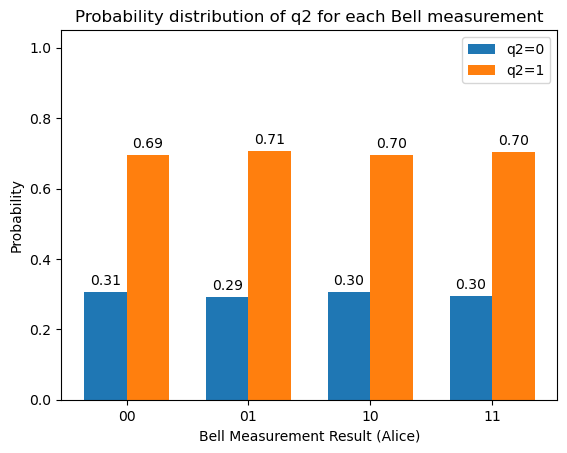

Qiskit Success Probability = 0.36845
Mathematical Probability = 0.3678794411714424
(Fidelity for each Bell measurement outcome:)
Bell result 00: Fidelity = 1.0000
Bell result 01: Fidelity = 0.9999
Bell result 10: Fidelity = 1.0000
Bell result 11: Fidelity = 1.0000


In [3]:
success, fail = 0, 0
Bell_states = {}

# First: filter outcomes with escort qubits = '11'
for outcome, count in counts.items():
    if outcome[-1] == '1' and outcome[-2] == '1':  # Escort qubits must be '1'
        success += count
        Bell_states[outcome] = Bell_states.get(outcome, 0) + count
    else:
        fail += count

total = success + fail

# Now: classify based on Alice's Bell measurement (c2 and c3, i.e., -3 and -4)
Bell_measurement_results = {'00': {}, '01': {}, '10': {}, '11': {}}

for outcome, count in Bell_states.items():
    bell_result = outcome[-4] + outcome[-3]  # Note order: q1 then q0
    output_bit = outcome[-5] 

    if output_bit in Bell_measurement_results[bell_result]:
        Bell_measurement_results[bell_result][output_bit] += count
    else:
        Bell_measurement_results[bell_result][output_bit] = count

# Prepare data for plotting
labels = []
probs_0 = []
probs_1 = []

for bell_result in ['00', '01', '10', '11']:
    result_counts = Bell_measurement_results[bell_result]
    total_counts = sum(result_counts.values())
    if total_counts > 0:
        prob0 = result_counts.get('0', 0) / total_counts
        prob1 = result_counts.get('1', 0) / total_counts
    else:
        prob0, prob1 = 0, 0

    labels.append(bell_result)
    probs_0.append(prob0)
    probs_1.append(prob1)

# Plot grouped bar chart
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, probs_0, width, label='q2=0')
rects2 = ax.bar(x + width/2, probs_1, width, label='q2=1')

# Labels and title
ax.set_ylabel('Probability')
ax.set_xlabel('Bell Measurement Result (Alice)')
ax.set_title('Probability distribution of q2 for each Bell measurement')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display probability numbers on top
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim(0, 1.05)
plt.show()

# Final success probability:
print('Qiskit Success Probability =', success / total)
print('Mathematical Probability =', ((1 - r1) * (1 - r2)))

########################################
print("(Fidelity for each Bell measurement outcome:)")
for bell_result, result_counts in Bell_measurement_results.items():
    total_counts = sum(result_counts.values())
    if total_counts > 0:
        p0 = result_counts.get('0', 0) / total_counts
        p1 = result_counts.get('1', 0) / total_counts

        # Fidelity formula
        fidelity = (alpha**2) * p0 + (beta**2) * p1 + 2 * alpha * beta * np.sqrt(p0 * p1)
        print(f"Bell result {bell_result}: Fidelity = {fidelity:.4f}")
    else:
        print(f"Bell result {bell_result}: No successful counts (fidelity undefined)")